In [2]:
import torch
import matplotlib.pyplot as plt
from scipy.stats import t

In [101]:
HIGH_TAIL_INIT = 0.9
SQRT_2 = torch.sqrt(torch.tensor(2.0))
PI = torch.tensor(torch.pi)
SQRT_PI = torch.tensor(torch.pi).sqrt()
MIN_ERFC_INV = torch.tensor(1e-6)

def _erfcinv(x):
    # with torch.no_grad():
    #     x = torch.clamp(x, min=MIN_ERFC_INV)
    return -torch.special.ndtri(0.5 * x) / SQRT_2

def _small_erfcinv(x, tail_param):
    """
    Use series expansion for erfcinv(x) as x->0, using subsitution for
    log x^-2
    """
    log_z_sq = 2 * torch.log(1 + x * tail_param) / tail_param

    inner = torch.log(2 / PI) + log_z_sq
    inner -= (torch.log(2 / PI) + log_z_sq).log()

    z = inner.pow(0.5) / SQRT_2

    return z

def _extreme_transform_and_lad(z, tail_param):
    g = torch.erfc(z / SQRT_2)
    x = (torch.pow(g, -tail_param) - 1) / tail_param

    lad = torch.log(g) * (-tail_param - 1)
    lad -= 0.5 * torch.square(z)
    lad += torch.log(SQRT_2 / SQRT_PI)

    return x, lad

def _extreme_inverse_and_lad(x, tail_param):
    inner = 1 + tail_param * x
    g = torch.pow(inner, -1 / tail_param)

    stable_g = g > MIN_ERFC_INV

    erfcinv_val = torch.zeros_like(x)
    erfcinv_val[stable_g] = _erfcinv(g[stable_g])
    erfcinv_val[~stable_g] = _small_erfcinv(x[~stable_g], tail_param)

    z = SQRT_2 * erfcinv_val

    lad = (-1 - 1 / tail_param) * torch.log(inner)
    lad += torch.square(erfcinv_val)
    lad += torch.log(SQRT_PI / SQRT_2)

    return z, lad

def _old_extreme_inverse_and_lad(x, tail_param):
    inner = 1 + tail_param * x
    g = torch.pow(inner, -1 / tail_param)
    erfcinv_val = _erfcinv(g)

    z = SQRT_2 * erfcinv_val

    lad = (-1 - 1 / tail_param) * torch.log(inner)
    lad += torch.square(erfcinv_val)
    lad += torch.log(SQRT_PI / SQRT_2)

    return z, lad

In [102]:
q_start = 0.9
q_end = 0.99
tail_value = 0.01
tail_target = 0.5
ins_x = torch.linspace(t(tail_target, 0., 1.).ppf(q_start), t(tail_target, 0., 1.).ppf(q_end), 1000)

grads = []
for x in ins_x:
    tail_param = torch.tensor(tail_value, requires_grad=True)
    z, lad = _old_extreme_inverse_and_lad(x, tail_param)
    z.backward()
    with torch.no_grad():
        grads.append(tail_param.grad)

new_grads = []
for x in ins_x:
    tail_param = torch.tensor(tail_value, requires_grad=True)
    z, lad = _extreme_inverse_and_lad(x, tail_param)
    z.backward()
    with torch.no_grad():
        new_grads.append(tail_param.grad)

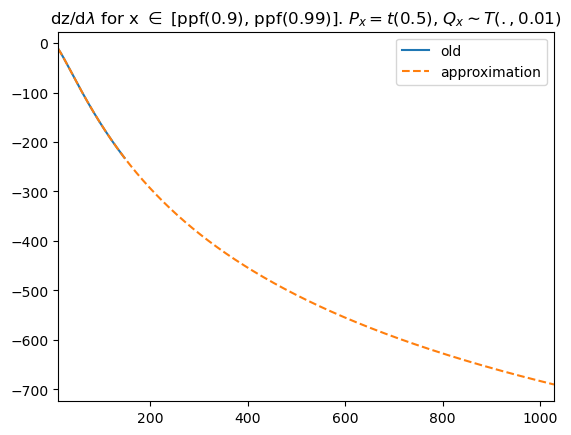

In [103]:
plt.plot(ins_x, torch.hstack(grads), label='old')
plt.plot(ins_x, torch.hstack(new_grads), linestyle='--', label='approximation')
plt.xlim([ins_x.min(), ins_x.max()])
plt.legend()
plt.title(f'dz/d$\lambda$ for x $\in$ [ppf({q_start}), ppf({q_end})]. $P_x=t({tail_target})$, $Q_x \sim T(., {tail_value})$')
plt.show()

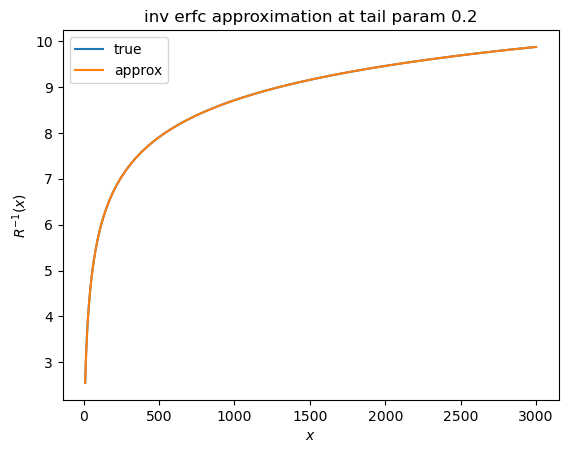

In [52]:
x = torch.linspace(1e1, 3e3, 1000).to(torch.float32)
tail_param = torch.tensor(.05)
inner = 1 + tail_param * x
g = torch.pow(inner, -1 / tail_param)

plt.plot(x, _erfcinv(g), label='true')
plt.plot(x, _small_erfcinv(x, tail_param), label='approx')

plt.legend()
plt.title('inv erfc approximation at tail param 0.2')
plt.xlabel('$x$')
plt.ylabel('$R^{-1}(x)$')
plt.show()

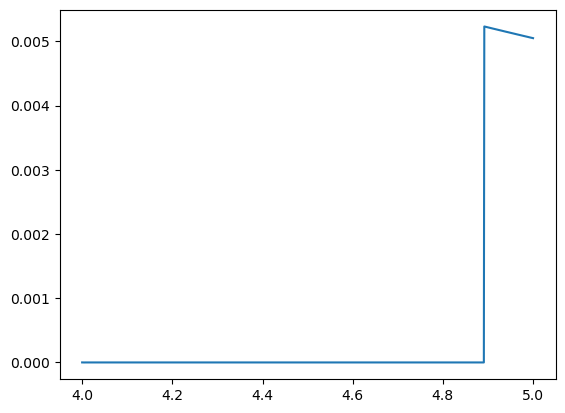

In [104]:
from tailnflows.models.extreme_transformations import _tail_forward, _tail_inverse, _extreme_inverse_and_lad, _extreme_transform_and_lad

z = torch.linspace(4, 5, 1000)

tail_param = torch.tensor(1.)
x, _ = _extreme_transform_and_lad(z, tail_param)
inv_z, _ = _extreme_inverse_and_lad(x, tail_param)

plt.plot(z, z - inv_z)

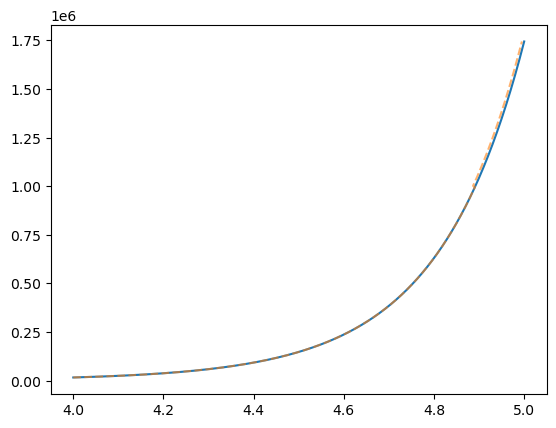

In [110]:
plt.plot(z, x)
plt.plot(inv_z, x, alpha=0.6, linestyle='--')